# Norway EV Highway - Part II - Data Analysis
## What drives people to buy EV cars?
Authors: Team CROWS composed by
- 314205 - Jostein Leirgulen 
- 270226 - Max Chevron 
- 321733 - Shasha Jiang 

Date: 18.12.2020 

### Purpose of this notebook: 
Investigate what drives Norwegians to buy EVs. We have split consumer behaviour in four categories: 
  - Economical factors
  - New EV model releases
  - Range anxiety
  - Environmental concerns
The goal is to see which one of these categories is the most impactfull. 

We therefore start by importing the pickle datasets created in the Part I notebook.

Then we do a two folds analysis. 

The first is to investigate if specific events which can be linked to the categories have an influence on the Norway EV sales trend 

Second we look at some historical trends of Google searches which are also linked to these four categories. We select 5 keywords by category and individually apply them on top of an Autoreggresion model. With out of sample prediction, if the predictability improves, then the keywords helps to explain the evolution of the sales and is therefore considered linked to consumer behaviour. 

In [1]:
import pickle
import pandas as pd 
from dateutil import relativedelta as rdelta
from datetime import datetime, date, timedelta
import time
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
from pytrends.request import TrendReq
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.regression.linear_model as lm
from sklearn.metrics import mean_absolute_error

## Load Dataframes from Notebook Part I

In [2]:
df_inter = pd.read_pickle('pytrends.pickle')
df_sales = pd.read_pickle('sales.pickle')

# Step 1 - Discrete OLS regression for dates analysis

The idea here is to assess if certain events affected the evolution of EV market share. 

The model for this regression is the following: 

log(ev_share) = $\beta_0 + \beta_1\Delta t$ + $\beta_2\cdot$event + $\beta_3\Delta t\cdot$event
-	$\beta_0$ = First intercept 
-	$\beta_1$ = Trend evolution with time ($\Delta t$ = Days from event)
-	$\beta_2$ = Additional offset on event day
-	$\beta_3$ = Change of slope after the event


In [3]:
'''
Function Goal:  Wrangle data to get a DataFrame ready to go through OLS regression. 
	            1) Add a new categorical column with value 0 before the event and 1 after
	            2) Create a new dataset centred around this date
	            3) Add another column with the number of days before and after the event (= 0 on event day)
	            4) Consider a grace period upon which the regression will ignore all values between the event day and the end of the grace period 
input:          evms - df with "ev_sales" and "log_ev_sales" as columns
                event_row = name of event, event date and grace period end date
output:         DataFrame with shrinked timespan and columns: log_ev_share, event label, days from event
'''
def get_date_regression_df(evms, event_row):

    # Extract day of the event and days of grace period after the event
    date_event = event_row[1]  
    grace_period = event_row[2]

    # 1) Add selected date as a feature [0 before,1 after]
    evms['event'] =  evms.date > date_event
    evms['event'] = evms['event'].apply(lambda x: int(x == True))

    # 2) Keep only data which has as many dates before and after the event (centering) 
    length_after = date_end - date_event
    length_before = date_event - date_start
    delta_t_max = min(length_after, length_before) # get the most constraining time boundary between available dates before and after the event
    data_a = pd.to_datetime(date_event - delta_t_max)
    date_b = pd.to_datetime(date_event + delta_t_max)
    evms_centered = evms.loc[(evms.date>data_a) & (evms.date<date_b)]

    # 3) Have a detla_t column with 0 fixed on the event day
    evms_centered['delta_t'] = evms_centered['date'].apply(lambda x: x - date_event).dt.days

    # 4) Drop datapoints within the grace period
    evms_centered_graced = evms_centered.loc[(evms_centered.delta_t<=0) | (evms_centered.date>grace_period)]

    # Final dataset for regression
    df = evms_centered_graced
    df.set_index('date', inplace=True)

    return df

In [4]:
'''
Function Goal:  Ordinary Least Square regression and return the prediction based on in-sample testing
input:          df = DataFrame with shrinked timespan and columns: log_ev_share, event label, days from event
                formula = patsy syntax formula for regression
                features 
output:         prediction
'''
def OLS(df, formula, features):
    model = smf.ols(formula=formula, data=df).fit()
    coef = model.params

    # predict the current value with obtained coefficients
    prediction = coef[0]
    for j in range(1,len(coef)):
        prediction = prediction + coef[j]*df[features[j-1]]

    return prediction

In [5]:
# Get the start and end dates of the sales dataset
date_start = df_sales.index[0]
date_end = df_sales.index[len(df_sales)-1]

# Build new DataFrame summarising the events

# Market share data set to use
evms = pd.DataFrame() # evms = EV Market Share
evms['date'] = pd.to_datetime(df_sales.index)
evms['ev_share'] = df_sales.ev_share.values
evms['log_ev_share'] = np.log(evms.ev_share + 0.1) # The market share grows quadratically, to make the predictor linear, take the log

# Create a new DataFrame with all the 4 key dates within our study timespan 
d = {'events': ["Nissan Leaf first release", "Tesla supercharging system start", "Paris agreement anouncement", "Tesla model 3 release"], 
     'dates': ["2010-12-01" ,"2013-07-01", "2015-01-04","2019-02-01"]}

# Define a grace period upon which data will not be used for the regression. 
# As dates are not exact and there is a always a time to action between event and purchase, we ignored the month ahead event.
grace_period = timedelta(days=30) # 1 month of grace period

# Events summary DataFrame
df_dates = pd.DataFrame(data=d)
df_dates['grace_end'] = df_dates.dates.map(lambda x: pd.to_datetime(x) + grace_period) 
df_dates.dates = pd.to_datetime(df_dates.dates)
df_dates

,events,dates,grace_end
0,Nissan Leaf first release,2010-12-01,2010-12-31
1,Tesla supercharging system start,2013-07-01,2013-07-31
2,Paris agreement anouncement,2015-01-04,2015-02-03
3,Tesla model 3 release,2019-02-01,2019-03-03


In [6]:
# The predictor will be the log of EV shares as it grows quadratically.
# The slope will always be growing after the date if we do not take the logarithm.
predictor = 'log_ev_share'

# The event model: 
formula_event = predictor + ' ~ delta_t + delta_t*event + event'
features_event = ['delta_t', 'event', 'delta_t*event']

# Get a dataframe for each event which centers the event with same amount of dates before and after and add a feature of 0 before the event and 1 after
# Then do a dictionary with all the new dataframes keyed with the event name
dic_of_df = dict()
for i in range(0,len(df_dates)):
    df = get_date_regression_df(evms, df_dates.iloc[i,:]) # Create a new DataFrame centered around the event and with new columns as described in the funciton
    df['delta_t*event'] = df.delta_t * df.event # This column needs to be added so that it can be used in the prediction (its a features which combines two features)
    df['prediction'] = OLS(df, formula_event, features_event) # Actual fitting and in-sample prediction
    dic = {df_dates.events[i]: df} # create a dictionary with the event name as the key
    dic_of_df.update(dic) # Append this dictionary to the other ones

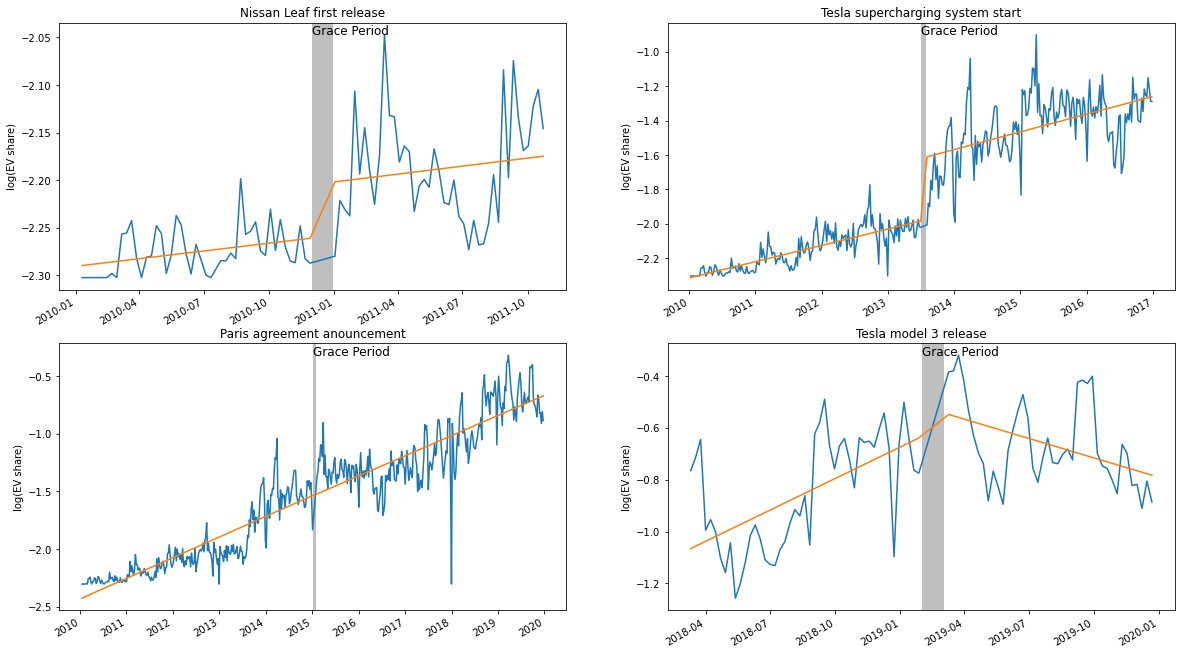

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

for axe, i in zip(axs.flat, range(0,4)):
    dic_of_df[df_dates.events[i]][predictor].plot(ax=axe) 
    dic_of_df[df_dates.events[i]].prediction.plot(ax=axe)
    grace_start = df_dates.dates[i]
    grace_end = df_dates.grace_end[i]
    axe.axvspan(grace_start, grace_end, color='grey', alpha=0.5, lw=0)
    axe.set_title(df_dates.events[i])
    axe.set_ylabel('log(EV share)')
    axe.set_xlabel('')
    axe.text(grace_start, dic_of_df[df_dates.events[i]][predictor].max(), 'Grace Period', fontsize=12)

plt.show()

For these results it seems like the Nissan leaf and the Tesla superchargers had the most impact on EV sales. Although less mediatised than Tesla, Nissan leaf was really THE car which made EV accessible for the mass market. The Tesla model 3 shows a big growth right after release but this growth doesn’t show itself to be steady in time. Additionally, it doesn’t seem like the growth of environmental concerns brought by the Paris climate agreement made a paradigm change in EV purchases. This method yields interesting results but has two key drawbacks. 
- We cannot assess the impact of economical factors on the consumer behaviour as we do not have any major events within this 10-year window. 
- Some other nonrelated events may superpose in the background which may also influence consumer behaviour. This makes it hard to dissociate categories among each other and avoid confounds. 

Another method is clearly needed to draw some stronger conclusions. 

# Step 2 - Autoregression analysis using Statsmodels

In [8]:
'''
Function Goal: Plot either baseline or model with keywords
Function input: sales - df with "ev_sales" as a column
                trends - df containing all google trends data
                keywords - list specifying which trends to use
                n_test - number of weeks that will be used for training
Function output: List of predicted sales using the fitted model

HOW TO PLOT BASELINE: Just pass sales (or market share), nothing else
HOW TO PLOT IMPROVED: Pass sales, trends and keywords
'''

def pred_sales_AR(sales_df, trends=None, keywords=[], n_test=17*4, disp=True):
    
    ## Instantiate models - create baseline if no trends dataframe is passed
    if trends is None:
        AR_model = AutoReg(sales_df["ev_share"],
                           lags=[1, 52],
                           hold_back = n_test,
                           old_names=False)
    else:
        AR_model = AutoReg(sales_df["ev_share"],
                           lags=[1, 52],
                           hold_back = n_test,
                           exog=trends[keywords],
                           old_names=False)
    
    ## Fit model
    AR_fit = AR_model.fit()
    
    ## Predict values using model
    pred_sales = AR_fit.predict(start=n_test) 

    ## Print summary
    if(disp):
        display(AR_fit.summary())
    
    return pred_sales, AR_fit.aic

In [9]:
'''
Function goal: Calculate percentage improvement of improved model compared to baseline model
'''

def calc_MAE(sales_df, baseline, improved, n_test=17*4):
    
    ## Slice out test set
    df_sales_test = sales_df.iloc[n_test:,:]
    
    ## Calculate totall MAE
    baseline_MAE = mean_absolute_error(df_sales_test["ev_share"], baseline)
    improved_MAE = mean_absolute_error(df_sales_test["ev_share"], improved)
    
    ## Calculate overall improvement and return it
    return ((baseline_MAE-improved_MAE)/baseline_MAE)*100

In [10]:
'''
Function goal: Plot models over empirical data
'''

def plot_AR(sales, baseline, improved, zoom_year=False):
    
    ## Create figure
    fig, ax = plt.subplots()
    
    ## Plot empirical
    sales["ev_share"].plot(figsize=(15,5))
    
    ## Iteratively plot predicted
    baseline.plot(figsize=(15,5))
    improved.plot(figsize=(15,5))

    ### Add legend
    plt.legend((['Actual', 'Base', 'Improved']))

    ### Add axis label and header
    ax.set_ylabel('Market Share')
    ax.set_xlabel('Date')
    ax.set_title('Market share of EV-vehicles in Norway')
    
    if(zoom_year):
        ax.set_xlim([date(2018, 1, 1), date(2019,1,1)])

In [11]:
# Create both baseline and improved model with best keywords
pred_sales_baseline, _ = pred_sales_AR(df_sales, disp=False)
pred_sales_improved, _ = pred_sales_AR(df_sales, df_inter, 
                                       keywords=["Elbil avgift", "Elbil parkering", "Elbil pris", "Tesla", "Nissan Leaf"], 
                                       disp=False)

C:\Users\maxch\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


In [12]:
# Calculate MAE improvement
MAE_improvement = calc_MAE(df_sales, pred_sales_baseline, pred_sales_improved)
print('The MAE between base model and improved model is improved by: {:.3f}% '.format(MAE_improvement))

The MAE between base model and improved model is improved by: 3.679% 


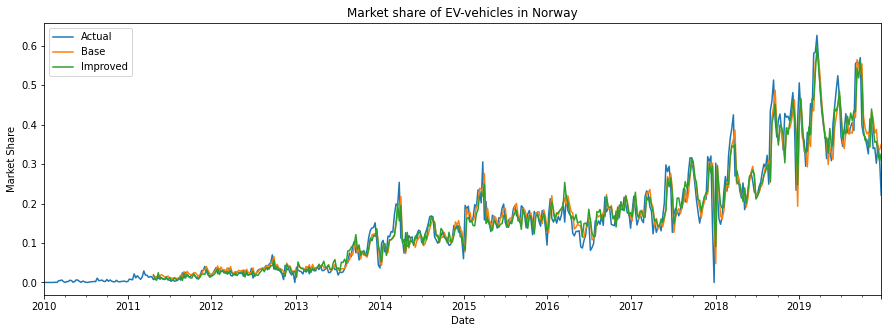

In [13]:
plot_AR(df_sales, pred_sales_baseline, pred_sales_improved)

Plot is to be used for visual effect in the datastory, not for analysis

## Plotting evaluation metrics

In [14]:
## Create lists to be iterated over, and ultimately made into a dataframe
AIC_improvement = []
MAE_improvement = []
AIC_keyword = []

## Get all available keywords as a list to be iterated over
all_keywords = df_inter.columns.to_list()
for kw in all_keywords:
    
    ## Predict market share for given keyword and calculate MAE
    pred_MarketShare, AIC = pred_sales_AR(df_sales, df_inter, keywords=kw, disp=False)
    MAE = calc_MAE(df_sales, pred_sales_baseline, pred_MarketShare)
    
    ## Systematically append values to list
    AIC_keyword.append(kw)
    MAE_improvement.append(MAE)
    AIC_improvement.append(AIC)

In [15]:
## Make each list into a dataframe
AIC_keyword_df = pd.DataFrame(AIC_keyword, columns=['Keywords'])
AIC_improvement_df = pd.DataFrame(AIC_improvement, columns=['AIC'])
MAE_improvement = pd.DataFrame(MAE_improvement, columns=['MAE'])

## concatenate
AIC_df = pd.concat([AIC_keyword_df, AIC_improvement_df, MAE_improvement], join='outer', axis=1)

## finally sort according to AIC
AIC_df = AIC_df.sort_values(by='AIC', ascending=False)

### Plot results with Shared y axis

#### MAE background:

MAE = $\frac{\Sigma_{i=1}^{n}|A_i - P_i|}{n}$ where A = actual market share and P = predicted market share (either base or trend)

#### AIC background: 
On the left Akaike's Informatino Criterion (AIC) is displayed, which is a common metric to use in order to evaluate the in-sample performance of a model. A lower value of AIC signifies a better in-sample fit. It is a metric that calculates information entropy through the negative log of maximum likelihood, while penalizing for added complexity by adding parameters. Low information entropy is desired, so the lowest AIC value is the best one

 However, in-sample fit does not neccesarily lead to prediction efficacy on yet-unseen data. Displayed on the right is the percentage improvement for Mean Absolute Error (MAE) from the baseline model to the AR model with keywords.

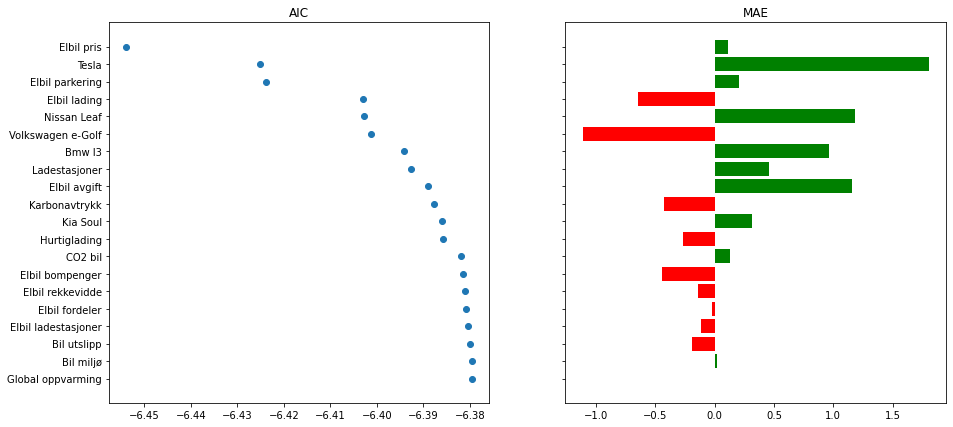

In [16]:
y = np.linspace(1, 20, 20)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,7))
ax1.scatter(AIC_df["AIC"], y)
ax1.set_yticks(y)
ax1.set_yticklabels(AIC_df["Keywords"]);
ax1.set_title('AIC')

colormat=np.where(AIC_df['MAE']>0, 'g','r')
ax2.barh(y, AIC_df['MAE'], color=colormat)
ax2.set_yticks(y)
ax2.set_yticklabels(AIC_df["Keywords"]);
ax2.set_title('MAE')

plt.show()

The evaluation of the keywords is done similar to how it was done in the Google Trends data. First each keyword is fit separately, checking the AIC value for in-sample fits. Secondly each keyword is evaluated out-of-sample, which provides, a strong indication for which keywords are best to combine. Through experimentation, the best keywords is found to be:

"Elbil avgift", "Elbil parkering", "Elbil pris", "Tesla", "Nissan Leaf"

With a improved model MAE goes up 3.68% in comparison to the baseline MAE. By looking at the category of the keywords, we can determine that keywords relating to EV models and economic considerations are more helpful in predicting EV market share than those for environment and climate. This is the essential finding, but it's expounded opon if its significant to solely rely on Google Trends to determine what motivates people in the data story.